# Analysis of Genome-wide CRISPR Screen in Primary Human T Cells

Here I analyze [data](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA487352) from a [genome-wide CRISPR screen in primary human T cells](https://www.sciencedirect.com/science/article/pii/S0092867418313333) downloaded from the NCBI Sequence Read Archive (SRA) database. Primary human CD8+ T cells were isolated from four donors, stimulated, transduced with the Brunello single-guide RNA (sgRNA) library, electroporated with Cas9, and then restimulated. Cells were then sorted by into 'non-proliferating' cells and highly proliferating cells followed by sequencing of the two populations.

The steps followed in this analysis are:
- downloading of the raw FASTQ data from the SRA database ([prefetch and fasterq-dump](https://github.com/ncbi/sra-tools/wiki/08.-prefetch-and-fasterq-dump))
- quantifying the abundance of the 77,441 sgRNAs in the 8 samples (4 donors, 2 cell populations each)
- statistical tests to assess the significance of sgRNA or gene knockout effects between 'non-proliferating' cells and highly proliferating cells

[MAGeCK](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0554-4) is used for the last two steps.

Downstream analysis of the output of MAGeCK is subsequently performed in an R notebook.

## 1. Download raw FASTQ files from NCBI SRA

In [2]:
# downloading of the raw FASTQ data from the SRA database (prefetch)
!~/sratools/sratoolkit.3.0.10-mac-x86_64/bin/prefetch \
    SRR7741075 SRR7741076 SRR7741083 SRR7741084 \
    SRR7741090 SRR7741089 SRR7741092 SRR7741091 \
    --output-directory fastq
!ls -1t fastq


2023-12-29T05:04:14 prefetch.3.0.10: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2023-12-29T05:04:15 prefetch.3.0.10: 1) Downloading 'SRR7741075'...
2023-12-29T05:04:15 prefetch.3.0.10: SRA Normalized Format file is being retrieved, if this is different from your preference, it may be due to current file availability.
2023-12-29T05:04:15 prefetch.3.0.10:  Downloading via HTTPS...
2023-12-29T05:09:30 prefetch.3.0.10:  HTTPS download succeed
2023-12-29T05:09:32 prefetch.3.0.10:  'SRR7741075' is valid
2023-12-29T05:09:32 prefetch.3.0.10: 1) 'SRR7741075' was downloaded successfully
2023-12-29T05:09:33 prefetch.3.0.10: 'SRR7741075' has 0 unresolved dependencies

2023-12-29T05:09:33 prefetch.3.0.10: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2023-12-29T05:09:33 prefetch.3.0.10: 2) Downloading 'SRR7741076'...
2023-12-29T05:09:33 prefetch.3.0.10: SRA Normalized Format file is being retri

In [3]:
# extracting SRA files to FASTQ (fasterq-dump)
!~/sratools/sratoolkit.3.0.10-mac-x86_64/bin/fasterq-dump \
    SRR7741075 SRR7741076 SRR7741083 SRR7741084 \
    SRR7741090 SRR7741089 SRR7741092 SRR7741091 \
    --outdir fastq
!ls -1t fastq

spots read      : 43,100,130
reads read      : 86,200,260
reads written   : 43,100,130
reads 0-length  : 43,100,130
spots read      : 60,320,529
reads read      : 120,641,058
reads written   : 60,320,529
reads 0-length  : 60,320,529
spots read      : 53,785,275
reads read      : 107,570,550
reads written   : 53,785,275
reads 0-length  : 53,785,275
spots read      : 49,559,785
reads read      : 99,119,570
reads written   : 49,559,785
reads 0-length  : 49,559,785
spots read      : 41,609,090
reads read      : 83,218,180
reads written   : 41,609,090
reads 0-length  : 41,609,090
spots read      : 40,626,205
reads read      : 81,252,410
reads written   : 40,626,205
reads 0-length  : 40,626,205
spots read      : 38,830,899
reads read      : 77,661,798
reads written   : 38,830,899
reads 0-length  : 38,830,899
spots read      : 37,522,017
reads read      : 75,044,034
reads written   : 37,522,017
reads 0-length  : 37,522,017
SRR7741091.fastq
SRR7741092.fastq
SRR7741089.fastq
SRR7741090.fastq
SR

- delete .sra folders

In [4]:
# verify 8 sample fastq files present
!ls -1t fastq

SRR7741091.fastq
SRR7741092.fastq
SRR7741089.fastq
SRR7741090.fastq
SRR7741084.fastq
SRR7741083.fastq
SRR7741076.fastq
SRR7741075.fastq


## 2. Quantify abundance of sgRNAs in the 8 samples

We can then use `mageck count` from MAGeCK to count how many times each of the 77,441 sgRNAs appears in the 8 samples.

The inputs to the command are:
- the FASTQ files from the 8 samples
- the list of sgRNAs in the Brunello library with their sequences and the genes they target
- the list of non-targeting sgRNAs in the Brunello library

In [9]:
# download Brunello library sgRNA list
!wget \
    -O broadgpp-brunello-library-corrected.txt.zip \
    https://sourceforge.net/projects/mageck/files/libraries/broadgpp-brunello-library-corrected.txt.zip/download

--2023-12-29 06:25:47--  https://sourceforge.net/projects/mageck/files/libraries/broadgpp-brunello-library-corrected.txt.zip/download
Resolving sourceforge.net (sourceforge.net)... 104.18.37.111, 172.64.150.145
Connecting to sourceforge.net (sourceforge.net)|104.18.37.111|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/mageck/libraries/broadgpp-brunello-library-corrected.txt.zip?ts=gAAAAABljtbrtpMu-gBqXejel19oGmaF95wTsH2MNMCppnnmECp8OZuADpAxgKWEynSxCXgs0I1Cqgx_fWa5R_lJChyMfgZBxQ%3D%3D&use_mirror=versaweb&r= [following]
--2023-12-29 06:25:47--  https://downloads.sourceforge.net/project/mageck/libraries/broadgpp-brunello-library-corrected.txt.zip?ts=gAAAAABljtbrtpMu-gBqXejel19oGmaF95wTsH2MNMCppnnmECp8OZuADpAxgKWEynSxCXgs0I1Cqgx_fWa5R_lJChyMfgZBxQ%3D%3D&use_mirror=versaweb&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforg

In [10]:
# unzip Brunello library sgRNA list
!unzip broadgpp-brunello-library-corrected.txt.zip

Archive:  broadgpp-brunello-library-corrected.txt.zip
  inflating: broadgpp-brunello-library-corrected.txt  
   creating: __MACOSX/
  inflating: __MACOSX/._broadgpp-brunello-library-corrected.txt  


In [4]:
# load and view Brunello library sgRNA list
import pandas as pd

sgrna_lib = pd.read_csv('broadgpp-brunello-library-corrected.txt', sep='\t')
sgrna_lib

,sgRNAID,Seq,gene
0,43525_41331_AGATGACCACAAGTGAAAGG,AGATGACCACAAGTGAAAGG,MARCHF1
1,43525_41332_ATACAAAGACCAAACCACAC,ATACAAAGACCAAACCACAC,MARCHF1
2,43525_41333_GCGAACACCCGAGATCTCAG,GCGAACACCCGAGATCTCAG,MARCHF1
3,43525_41334_TCGACTTGCAGATCGCCCTG,TCGACTTGCAGATCGCCCTG,MARCHF1
4,43525_47963_AACAAGTCTGCTATTTGATG,AACAAGTCTGCTATTTGATG,MARCHF1
...,...,...,...
77436,ZZEF1_31850_TGCAAGGCTTGACCATCAGT,TGCAAGGCTTGACCATCAGT,ZZEF1
77437,ZZZ3_34327_ACAGACGATTGCTGTACTCG,ACAGACGATTGCTGTACTCG,ZZZ3
77438,ZZZ3_34328_AGAGTATAACGATGTTCTTG,AGAGTATAACGATGTTCTTG,ZZZ3
77439,ZZZ3_34329_GCAGAGTACCCGAGAATCAT,GCAGAGTACCCGAGAATCAT,ZZZ3


---
The Brunello sgRNA library has 76,441 sgRNAs targeting 19,114 genes and 1,000 non-targeting control sgRNAs (total 77,441 sgRNAs).

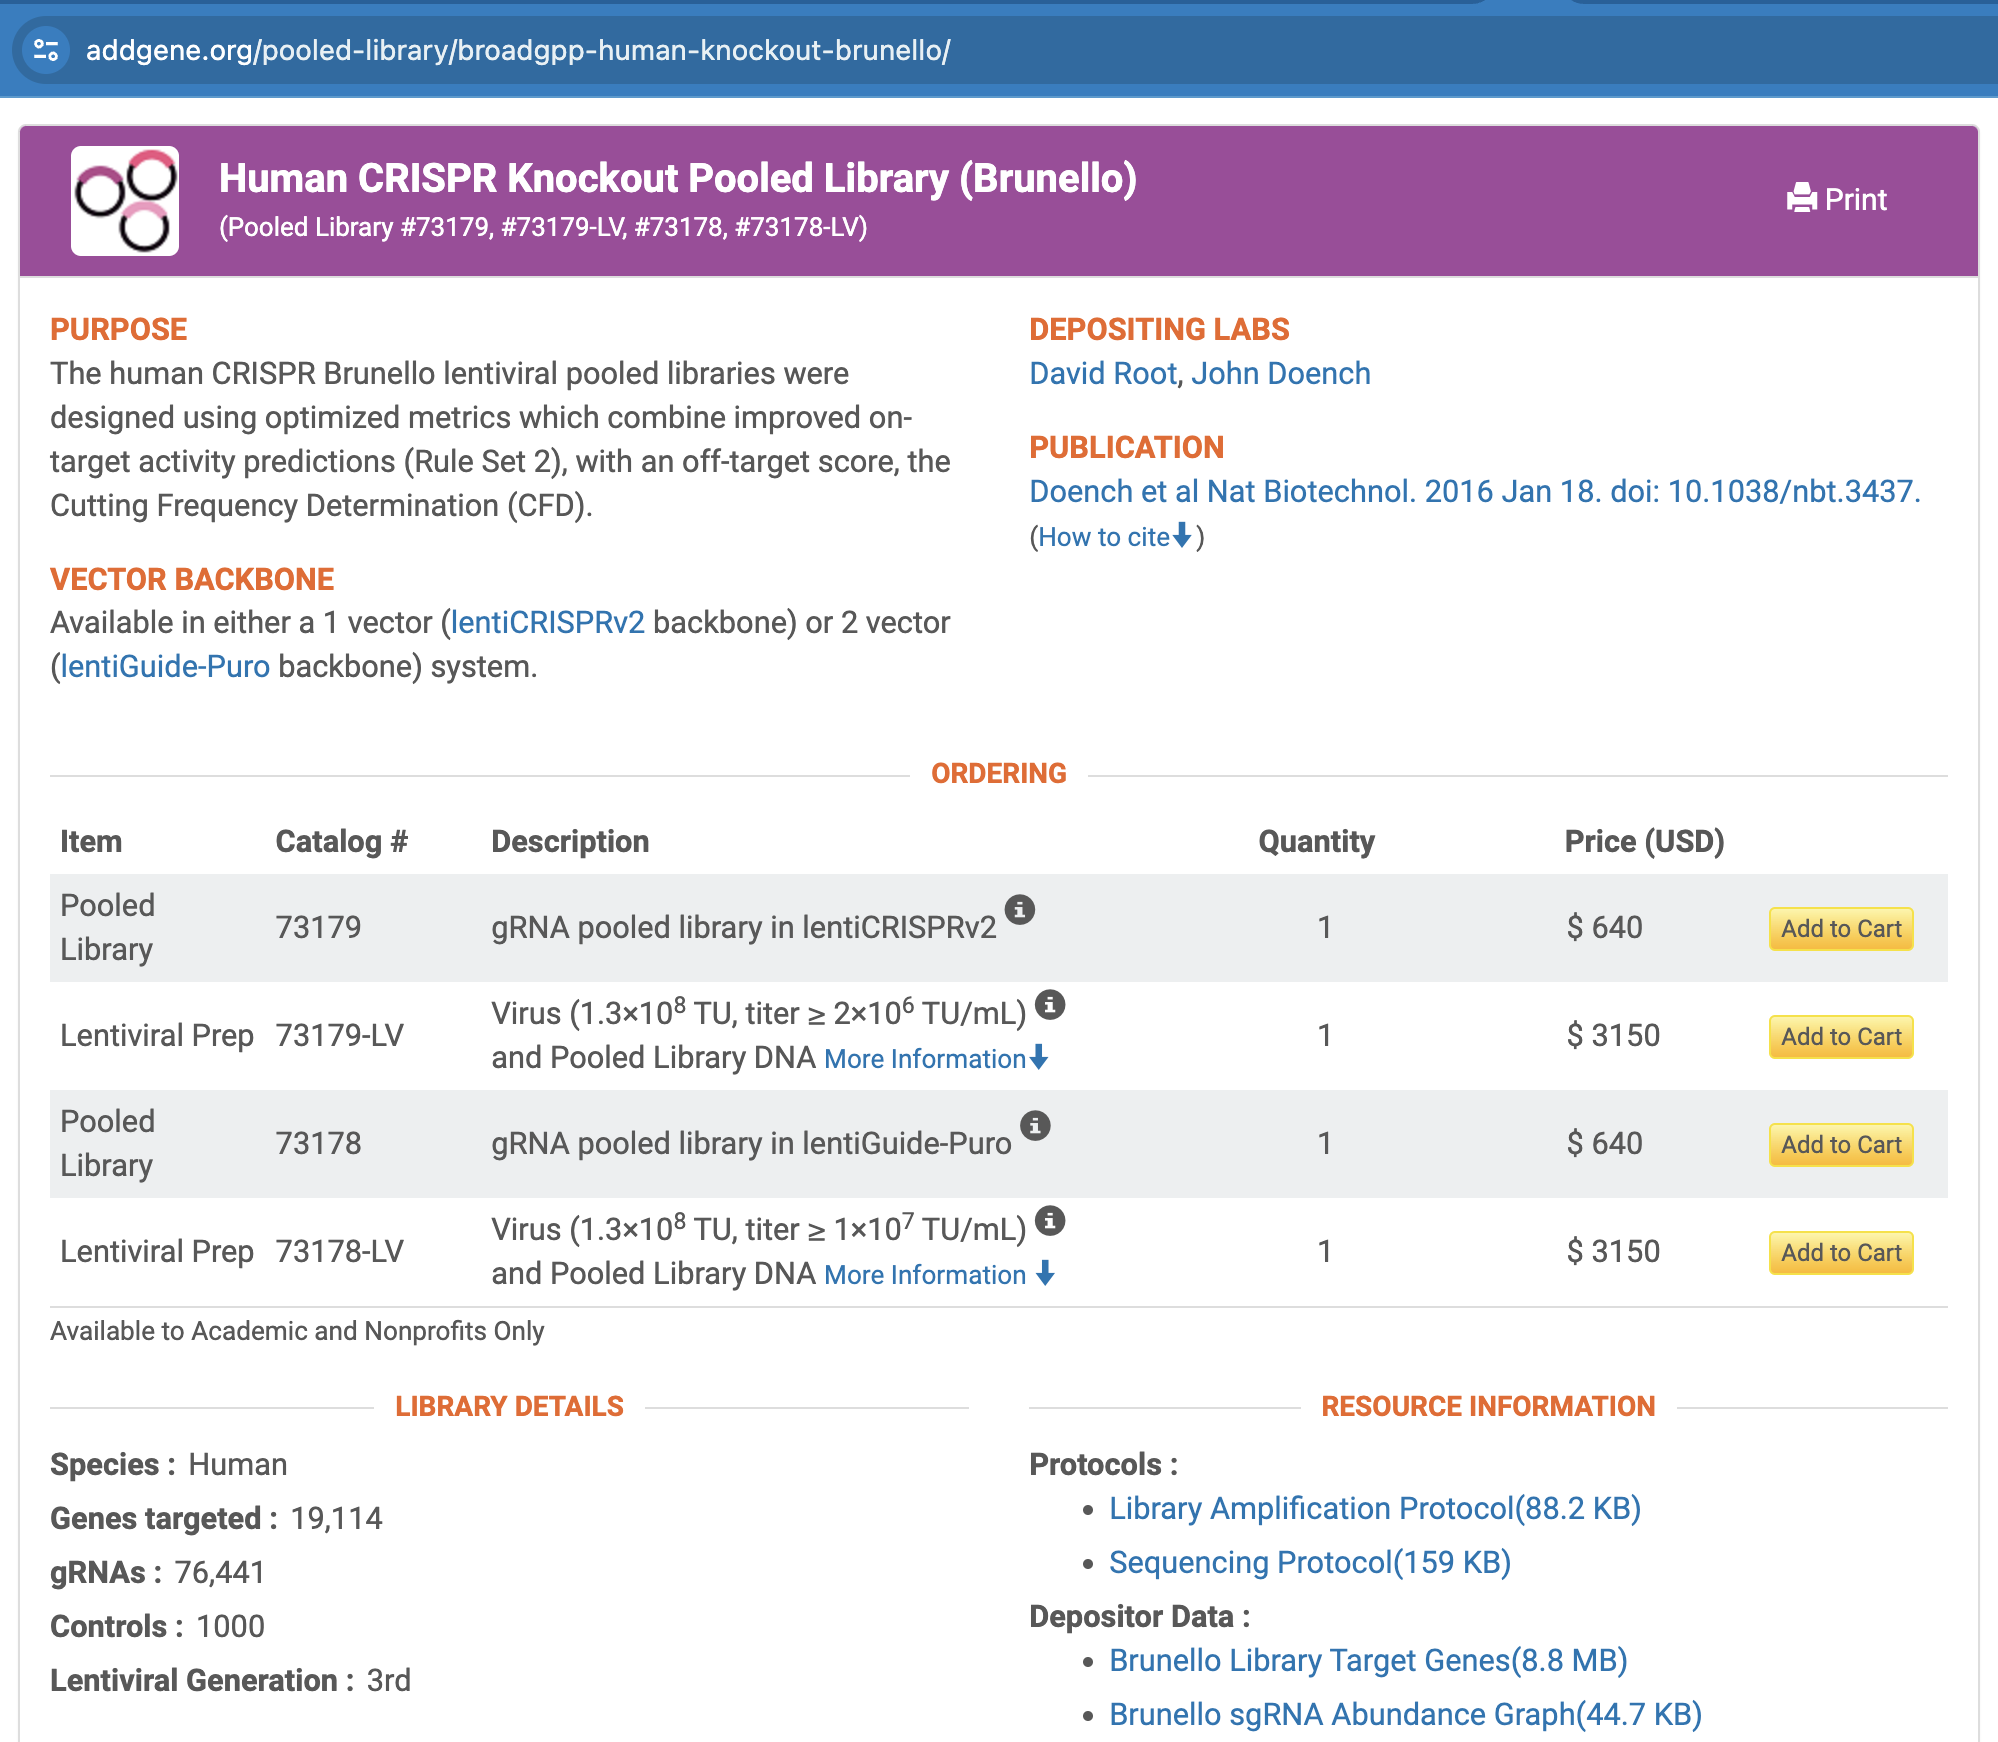

In [21]:
# view non-targeting control sgRNAs
sgrna_lib[sgrna_lib['gene']=='Non-Targeting-Control']

,sgRNAID,Seq,gene
43205,Non-Targeting-Control_76442_AAAAAGCTTCCGCCTGATGG,AAAAAGCTTCCGCCTGATGG,Non-Targeting-Control
43206,Non-Targeting-Control_76443_AAAACAGGACGATGTGCGGC,AAAACAGGACGATGTGCGGC,Non-Targeting-Control
43207,Non-Targeting-Control_76444_AAAACATCGACCGAAAGCGT,AAAACATCGACCGAAAGCGT,Non-Targeting-Control
43208,Non-Targeting-Control_76445_AAAATAGCAGTAAACTCAAC,AAAATAGCAGTAAACTCAAC,Non-Targeting-Control
43209,Non-Targeting-Control_76446_AAAATCGATGGGCTGAATCT,AAAATCGATGGGCTGAATCT,Non-Targeting-Control
...,...,...,...
44200,Non-Targeting-Control_77437_TTTGGTCAACGCATAGCTTG,TTTGGTCAACGCATAGCTTG,Non-Targeting-Control
44201,Non-Targeting-Control_77438_TTTTACCTTGTTCACATGGA,TTTTACCTTGTTCACATGGA,Non-Targeting-Control
44202,Non-Targeting-Control_77439_TTTTGACTCTAATCACCGGT,TTTTGACTCTAATCACCGGT,Non-Targeting-Control
44203,Non-Targeting-Control_77440_TTTTTAATACAAGGTAATCT,TTTTTAATACAAGGTAATCT,Non-Targeting-Control


In [23]:
# export negative ctrl sgRNA list
sgrna_lib['sgRNAID'][sgrna_lib['gene']=='Non-Targeting-Control'].to_csv('negative_ctrl_sgrna_list.txt', 
                                                                        header=False, index=False)
pd.read_csv('negative_ctrl_sgrna_list.txt', header=None)

,0
0,Non-Targeting-Control_76442_AAAAAGCTTCCGCCTGATGG
1,Non-Targeting-Control_76443_AAAACAGGACGATGTGCGGC
2,Non-Targeting-Control_76444_AAAACATCGACCGAAAGCGT
3,Non-Targeting-Control_76445_AAAATAGCAGTAAACTCAAC
4,Non-Targeting-Control_76446_AAAATCGATGGGCTGAATCT
...,...
995,Non-Targeting-Control_77437_TTTGGTCAACGCATAGCTTG
996,Non-Targeting-Control_77438_TTTTACCTTGTTCACATGGA
997,Non-Targeting-Control_77439_TTTTGACTCTAATCACCGGT
998,Non-Targeting-Control_77440_TTTTTAATACAAGGTAATCT


---
Now that we have all the inputs, we run a test run of the `mageck count` command to see how many bases need to be trimmed from each read before mapping to the sgRNA library list.

In [24]:
# mageck count: test run
!mageck count \
    --list-seq broadgpp-brunello-library-corrected.txt \
    --output-prefix test_run01 \
    --sample-label SRR7741075 \
    --fastq fastq/SRR7741075.fastq \
    --control-sgrna negative_ctrl_sgrna_list.txt \
    --test-run

INFO  @ Fri, 29 Dec 2023 07:06:08: Parameters: /Users/felixm/anaconda3/envs/mageck/bin/mageck count --list-seq broadgpp-brunello-library-corrected.txt --output-prefix test_run01 --sample-label SRR7741075 --fastq fastq/SRR7741075.fastq --control-sgrna negative_ctrl_sgrna_list.txt --test-run 
INFO  @ Fri, 29 Dec 2023 07:06:08: Welcome to MAGeCK v0.5.9.5. Command: count 
INFO  @ Fri, 29 Dec 2023 07:06:08: Header line of the library file detected; skip the first line ... 
INFO  @ Fri, 29 Dec 2023 07:06:08: Loading 77441 predefined sgRNAs. 
WARNING @ Fri, 29 Dec 2023 07:06:08: There are 0 sgRNAs with duplicated sequences. 
INFO  @ Fri, 29 Dec 2023 07:06:08: Parsing FASTQ file fastq/SRR7741075.fastq... 
INFO  @ Fri, 29 Dec 2023 07:06:08: Determining the trim-5 length of FASTQ file fastq/SRR7741075.fastq... 
INFO  @ Fri, 29 Dec 2023 07:06:09: Possible gRNA lengths:20 
INFO  @ Fri, 29 Dec 2023 07:06:09: Processing 0M reads ... 
INFO  @ Fri, 29 Dec 2023 07:06:10: Read length:51 
INFO  @ Fri, 29

---
Based on the test run, setting `--trim-5 18,19,20,21,22,23,24,25,26,27,28,29,30,31` should result in a high enough mapping rate.

We now count the sgRNA incidence in all 8 samples.

In [28]:
# mageck count: all gw samples
!mageck count \
    --list-seq broadgpp-brunello-library-corrected.txt \
    --output-prefix gw01 \
    --sample-label D3_Div,D3_NonDiv,D4_Div,D4_NonDiv,D5_NonDiv,D5_Div,D6_NonDiv,D6_Div \
    --fastq fastq/SRR7741075.fastq fastq/SRR7741076.fastq fastq/SRR7741083.fastq fastq/SRR7741084.fastq \
    fastq/SRR7741089.fastq fastq/SRR7741090.fastq fastq/SRR7741091.fastq fastq/SRR7741092.fastq \
    --control-sgrna negative_ctrl_sgrna_list.txt \
    --trim-5 18,19,20,21,22,23,24,25,26,27,28,29,30,31 \
    --keep-tmp

INFO  @ Fri, 29 Dec 2023 07:29:54: Parameters: /Users/felixm/anaconda3/envs/mageck/bin/mageck count --list-seq broadgpp-brunello-library-corrected.txt --output-prefix gw01 --sample-label D3_Div,D3_NonDiv,D4_Div,D4_NonDiv,D5_NonDiv,D5_Div,D6_NonDiv,D6_Div --fastq fastq/SRR7741075.fastq fastq/SRR7741076.fastq fastq/SRR7741083.fastq fastq/SRR7741084.fastq fastq/SRR7741089.fastq fastq/SRR7741090.fastq fastq/SRR7741091.fastq fastq/SRR7741092.fastq --control-sgrna negative_ctrl_sgrna_list.txt --trim-5 18,19,20,21,22,23,24,25,26,27,28,29,30,31 
INFO  @ Fri, 29 Dec 2023 07:29:54: Welcome to MAGeCK v0.5.9.5. Command: count 
INFO  @ Fri, 29 Dec 2023 07:29:54: Header line of the library file detected; skip the first line ... 
INFO  @ Fri, 29 Dec 2023 07:29:54: Loading 77441 predefined sgRNAs. 
WARNING @ Fri, 29 Dec 2023 07:29:54: There are 0 sgRNAs with duplicated sequences. 
INFO  @ Fri, 29 Dec 2023 07:29:54: Parsing FASTQ file fastq/SRR7741075.fastq... 
INFO  @ Fri, 29 Dec 2023 07:29:54: Specif

---
This outputs a count file containing for each of the 77,441 sgRNAs a count of how many times it was found in each of the 8 samples

In [33]:
# view count file output by mageck count
gw01_count = pd.read_csv('gw01.count.txt', sep="\t")
gw01_count

,sgRNA,Gene,D3_Div,D3_NonDiv,D4_Div,D4_NonDiv,D5_NonDiv,D5_Div,D6_NonDiv,D6_Div
0,Non-Targeting-Control_77256_TAGCTCGAGTCATTTCTCTA,Non-Targeting-Control,692,912,860,966,756,984,713,866
1,MRPS12_16476_GGATGAAGCAGACGGCCTCG,MRPS12,830,841,876,873,747,854,849,1091
2,C17orf67_68871_GCTCCTAAGATCTCGGCGAC,C17orf67,310,475,544,528,414,373,269,353
3,CYP1A2_4340_GTCAGCACATGCCCGAGCAA,CYP1A2,1127,1579,1437,1434,1177,920,851,983
4,PPM1K_62726_GCAGAATTGGCTCATCAATG,PPM1K,3406,1855,982,919,698,947,774,802
...,...,...,...,...,...,...,...,...,...,...
77436,TUBAL3_50173_TCTCGGATAAGGTACCAGGT,TUBAL3,0,0,0,0,0,0,0,0
77437,UBXN10_59424_GCTCTTTACCAAGACGAGAC,UBXN10,0,0,0,0,0,0,0,0
77438,UBXN8_21163_TCTCCCCAAGTTTATCTGAA,UBXN8,0,0,0,0,0,0,0,0
77439,XPO1_20360_TCTCAGGGAAACTCTTATGG,XPO1,0,0,0,0,0,0,0,0


This count matrix can now be utilized as input for `mageck test` to detect significant differences in selection between the two conditions for both sgRNAs and their corresponding genes.

## Statistical tests to assess the significance of sgRNA/gene knockout effects between 'non-proliferating' and highly-proliferating CD8+ T cells

In [30]:
# run mageck test
!mageck test \
    --count-table gw01.count.txt \
    --treatment-id D3_Div,D4_Div,D5_Div,D6_Div \
    --control-id D3_NonDiv,D4_NonDiv,D5_NonDiv,D6_NonDiv \
    --keep-tmp \
    --output-prefix gw01_test \
    --control-sgrna negative_ctrl_sgRNA_list.txt

INFO  @ Fri, 29 Dec 2023 08:12:06: Parameters: /Users/felixm/anaconda3/envs/mageck/bin/mageck test --count-table gw01.count.txt --treatment-id D3_Div,D4_Div,D5_Div,D6_Div --control-id D3_NonDiv,D4_NonDiv,D5_NonDiv,D6_NonDiv --keep-tmp --output-prefix gw01_test --control-sgrna negative_ctrl_sgRNA_list.txt 
INFO  @ Fri, 29 Dec 2023 08:12:06: Welcome to MAGeCK v0.5.9.5. Command: test 
INFO  @ Fri, 29 Dec 2023 08:12:06: Loading count table from gw01.count.txt  
INFO  @ Fri, 29 Dec 2023 08:12:06: Processing 1 lines.. 
INFO  @ Fri, 29 Dec 2023 08:12:06: Loaded 77441 records. 
INFO  @ Fri, 29 Dec 2023 08:12:06: 1000 out of 1000 control sgRNAs are found in count table. 
INFO  @ Fri, 29 Dec 2023 08:12:06: Loading Rnw template file: /Users/felixm/anaconda3/envs/mageck/lib/python3.10/site-packages/mageck/test_report.Rmd. 
INFO  @ Fri, 29 Dec 2023 08:12:06: Loading R template file: /Users/felixm/anaconda3/envs/mageck/lib/python3.10/site-packages/mageck/plot_template.RTemplate. 
INFO  @ Fri, 29 Dec

---
This outputs an sgRNA summary file and a gene summary file containing the sgRNA ranking results and gene ranking results respectively. These are analyzed in a subsequent R notebook.

In [7]:
pd.read_csv('gw01_test.sgrna_summary.txt', sep='\t')

,sgrna,Gene,control_count,treatment_count,control_mean,treat_mean,LFC,control_var,adj_var,score,p.low,p.high,p.twosided,FDR,high_in_treatment
0,CBLB_2430_TGCACAGAACTATCGTACCA,CBLB,1121.7/575.93/873.32/498.82,2049.9/2978.6/2534.3/4213.7,724.62,2756.50,1.926100,84305.00,7487.7,23.481000,1.000000e+00,3.182900e-122,6.365700e-122,4.929700e-117,True
1,CBLB_2432_TTCCGCAAAATAGAGCCCCA,CBLB,650.64/526.59/540.11/337.76,1309.6/2225.7/977.65/1808.4,533.35,1559.00,1.545700,17369.00,5389.7,13.971000,1.000000e+00,1.176300e-44,2.352600e-44,9.109500e-40,True
2,TCEB2_18807_GAGCAGCGGCTGTACAAGGT,TCEB2,4705.9/833.4/500.91/426.7,20193/375.65/906.35/2539.8,667.15,1723.10,1.367600,5474800.00,6852.4,12.756000,1.000000e+00,1.447600e-37,2.895100e-37,7.473400e-33,True
3,CD5_2575_CGGCTCAGCTGGTATGACCC,CD5,781.96/548.12/579.31/492.81,1534.9/2794.5/1074.9/1380.2,563.72,1457.60,1.369000,17715.00,5719.5,11.819000,1.000000e+00,1.554000e-32,3.108000e-32,6.017100e-28,True
4,LCP2_10545_AGCCACGAAGAGGACAATGG,LCP2,781.22/1325/1259.9/1101,199.22/255.41/144.76/146.28,1180.50,172.75,-2.765500,64300.00,12640.0,8.963200,1.577300e-19,1.000000e+00,3.154600e-19,4.886000e-15,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77436,OR1D5_21799_CAACGCTGTGTGAATGATGT,OR1D5,394.69/463.8/435.57/449.54,457.22/427.89/468.84/377.49,442.56,442.55,-0.000009,946.62,4412.0,0.000040,4.999800e-01,5.000200e-01,9.999700e-01,9.999900e-01,False
77437,PDE9A_13560_TTGTCGTGGACGCAGAACTG,PDE9A,729.29/642.32/694.73/808.93,689.09/493.4/752.95/734.92,712.01,712.01,-0.000006,4949.40,7347.9,0.000034,4.999900e-01,5.000100e-01,9.999700e-01,9.999900e-01,False
77438,GID4_48720_CCGGCGGGGGACACTCGGTG,GID4,187.7/190.18/180.76/204.34,251.47/179.12/198.77/138.02,188.94,188.94,0.000009,102.34,1771.2,0.000028,5.000100e-01,4.999900e-01,9.999800e-01,9.999900e-01,True
77439,CCL15_16999_GATGCTTTGTGAGATGTAGG,CCL15,315.31/440.47/411.61/423.1,428.91/444.47/271.15/405.8,417.36,417.36,0.000004,3671.40,4143.1,0.000017,5.000100e-01,4.999900e-01,9.999900e-01,9.999900e-01,True


In [6]:
pd.read_csv('gw01_test.gene_summary.txt', sep='\t')

,id,num,neg|score,neg|p-value,neg|fdr,neg|rank,neg|goodsgrna,neg|lfc,pos|score,pos|p-value,pos|fdr,pos|rank,pos|goodsgrna,pos|lfc
0,HSPA8,4,9.718700e-12,2.590100e-07,0.000066,1,4,-0.98591,1.000000e+00,1.000000e+00,1.000000,19112,0,-0.98591
1,LCP2,4,1.114400e-09,2.590100e-07,0.000066,2,4,-1.72740,1.000000e+00,1.000000e+00,1.000000,19108,0,-1.72740
2,EXOSC6,4,2.215300e-09,2.590100e-07,0.000066,3,3,-1.06430,7.673900e-01,8.631200e-01,1.000000,14341,0,-1.06430
3,LCK,4,2.302100e-09,2.590100e-07,0.000066,4,4,-0.66246,1.000000e+00,1.000000e+00,1.000000,19111,0,-0.66246
4,TAF1C,4,4.285400e-09,2.590100e-07,0.000066,5,4,-0.54272,1.000000e+00,1.000000e+00,1.000000,19110,0,-0.54272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19107,RPRD1B,4,1.000000e+00,9.999700e-01,1.000000,19108,0,0.50122,4.826100e-06,4.688100e-05,0.059736,15,4,0.50122
19108,CD8A,4,1.000000e+00,9.999700e-01,1.000000,19109,0,0.64707,4.794200e-06,4.688100e-05,0.059736,14,4,0.64707
19109,MEF2D,4,1.000000e+00,9.999900e-01,1.000000,19110,0,0.34340,2.182500e-07,1.295100e-06,0.002750,9,4,0.34340
19110,TMEM222,4,1.000000e+00,9.999900e-01,1.000000,19111,0,0.89430,5.787700e-08,2.590100e-07,0.000619,4,4,0.89430


## NEXT:
- R analysis of the outputs of `mageck count` and `mageck test`